Vehicle Detection Project

The goals / steps of this project are the following:

Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

Estimate a bounding box for vehicles detected.

### Histogram of Oriented Gradients (HOG)

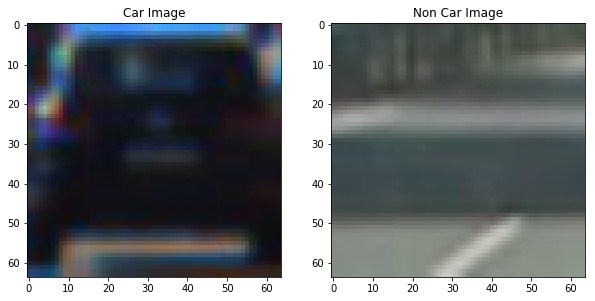

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os 
from skimage.feature import hog
from sklearn.svm import SVC

import time

from moviepy.editor import VideoFileClip
from IPython.display import HTML
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

cars=glob.glob("./data/cars/*.jpeg")
# cars= glob.glob("./data/cars_all/*.png")
notcars = glob.glob("./data/notcars/*.jpeg")

car_list =[plt.imread(car) for car in cars]
notcar_list = [plt.imread(notcar) for notcar in notcars]

def show(img_list, cols=1):
    fig = plt.figure(figsize=(20,5))
    length = len(img_list)
    row = length // cols
    for index in range(length):
        fig.add_subplot(row, cols, index+1)
        plt.imshow(img_list[index], cmap='gray')
    plt.show()

car_image=car_list[0]
noncar_image=notcar_list[0]

fig = plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(car_image, cmap='gray')
plt.title('Car Image')
plt.subplot(122)
plt.imshow(noncar_image, cmap='gray')
plt.title('Non Car Image')

In [2]:
def get_hog(image, channel='GRAY', orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True):
    img = np.copy(image)
    if channel == 'R':
        img = image[:,:,0]
    elif channel == 'G':
        img = image[:,:,1]
    elif channel == 'B':
        img = image[:,:,2]
    elif channel == 'GRAY':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    return return_list[0],return_list[1]

def get_hog_features(image, channel='GRAY', orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
#     image=plt.imread(image)
    img = np.copy(image)
    if channel == 'R':
        img = image[:,:,0]
    elif channel == 'G':
        img = image[:,:,1]
    elif channel == 'B':
        img = image[:,:,2]
    elif channel == 'GRAY':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hog_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    return hog_features#, return_list[1]#hog_features, hog_image
######
def get_color_hist(image, nbins=32, bins_range=(0, 256)):
    rhist =np.histogram(image[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    return hist_features

def get_bin_spatial(image, size=(32, 32)):
    features = cv2.resize(image, size).ravel() 
    return features

In [3]:
# car_hoged_features1, car_hoged_image1 = get_hog(car_image, channel='R', orient=9, pix_per_cell=9, cell_per_block=2)
# car_hoged_features2, car_hoged_image2 = get_hog(car_image, channel='G', orient=9, pix_per_cell=9, cell_per_block=2)
# car_hoged_features3, car_hoged_image3 = get_hog(car_image, channel='B', orient=9, pix_per_cell=9, cell_per_block=2)
# car_hoged_features4, car_hoged_image4 = get_hog(car_image, channel='GRAY', orient=9, pix_per_cell=9, cell_per_block=2)
# # noncar_hoged_features1, noncar_hoged_image1 = get_hog(noncar_image,channel='R', orient=9, pix_per_cell=8, cell_per_block=2)
# # noncar_hoged_features2, noncar_hoged_image2 = get_hog(noncar_image,channel='G', orient=9, pix_per_cell=8, cell_per_block=2)
# # noncar_hoged_features3, noncar_hoged_image3 = get_hog(noncar_image,channel='B', orient=9, pix_per_cell=8, cell_per_block=2)
# # noncar_hoged_features4, noncar_hoged_image4 = get_hog(noncar_image,channel='GRAY', orient=9, pix_per_cell=8, cell_per_block=2)

# fig = plt.figure(figsize=(20,16))
# plt.subplot(1,4,1)
# plt.imshow(car_hoged_image1, cmap='gray')
# plt.title('R channel')

# plt.subplot(1,4,2)
# plt.imshow(car_hoged_image2, cmap='gray')
# plt.title('G channel')

# plt.subplot(1,4,3)
# plt.imshow(car_hoged_image3, cmap='gray')
# plt.title('B channel')
# plt.subplot(1,4,4)
# plt.imshow(car_hoged_image4, cmap='gray')
# plt.title('GRAY Channel')
# ####
# # plt.subplot(2,4,5)
# # plt.imshow(noncar_hoged_image1, cmap='gray')
# # plt.title('R channel')

# # plt.subplot(2,4,6)
# # plt.imshow(noncar_hoged_image2, cmap='gray')
# # plt.title('G channel')

# # plt.subplot(2,4,7)
# # plt.imshow(noncar_hoged_image3, cmap='gray')
# # plt.title('B channel')
# # plt.subplot(2,4,8)
# # plt.imshow(noncar_hoged_image4, cmap='gray')
# # plt.title('GRAY Channel')

In [4]:
# car_hoged_features1, car_hoged_image1 = get_hog(car_image, channel='GRAY', orient=9, pix_per_cell=8, cell_per_block=2)
# car_hoged_features2, car_hoged_image2 = get_hog(car_image, channel='GRAY', orient=9, pix_per_cell=8, cell_per_block=3)
# car_hoged_features3, car_hoged_image3 = get_hog(car_image, channel='GRAY', orient=9, pix_per_cell=9, cell_per_block=3)
# car_hoged_features4, car_hoged_image4 = get_hog(car_image, channel='GRAY', orient=8, pix_per_cell=8, cell_per_block=2)
# fig = plt.figure(figsize=(20,16))
# plt.subplot(1,4,1)
# plt.imshow(car_hoged_image1, cmap='gray')
# plt.title('982')

# plt.subplot(1,4,2)
# plt.imshow(car_hoged_image2, cmap='gray')
# plt.title('983')

# plt.subplot(1,4,3)
# plt.imshow(car_hoged_image3, cmap='gray')
# plt.title('993')
# plt.subplot(1,4,4)
# plt.imshow(car_hoged_image4, cmap='gray')
# plt.title('882')

I take channel Gray with orient=9, pix_per_cell=8, cell_per_block=2

In [5]:
######################################################5555
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
#     print(color_space)
        # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space =='YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
            
    #2) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = get_bin_spatial(feature_image, size=spatial_size)
        #3) Append features to list
        img_features.append(spatial_features)
    #4) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = get_color_hist(feature_image, nbins=hist_bins)
        #5) Append features to list
        img_features.append(hist_features)
    #6) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
#     print(spatial_features.shape)
#     print(hist_features.shape)
#     print(hog_features.shape)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# get the features
spatial_feat = True     # Spatial features on or off
hist_feat = True       # Histogram features on or off
hog_feat = True 
# color_space='YCrCb' #YCrCb
color_space="RGB"
hist_bins = 32#16
hog_channel="ALL"
spatial_size=(32,32)#(16,16)

In [6]:
car_features =[]
start = time.time()


for img in car_list:
    car_features.append(single_img_features(img, color_space=color_space,
                                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                                           hist_feat=hist_feat, hog_feat=hog_feat, spatial_size=spatial_size))
notcar_features=[]
for img in notcar_list:
    notcar_features.append(single_img_features(img, color_space=color_space, hog_channel=hog_channel, 
                                               spatial_feat=spatial_feat,
                                               hist_feat=hist_feat, hog_feat=hog_feat,spatial_size=spatial_size))
end = time.time()
print("time cost is {:2f}".format(end-start))
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Normalize
X_scaler = StandardScaler().fit(X)
X = X_scaler.transform(X)
    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
#YCrCb

time cost is 133.515272


In [7]:
clf = SVC(kernel='linear',C=0.01)#rbf. 0.96 84s
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print("score is ",clf.score(X_test,y_test))
print("time cost is {:2f}".format(end-start))

score is  0.98275862069
time cost is 145.980388


    ### YUV 123svm 0.98 104s 123svm 0.98 106s 123svm 0.99,102s
    ### HLS 123svm 0,987 85s 123svm 0.997 89s 123svm 0.99 89s
    ### LUV 123svm 0.98 137s 123svm 0.982 137s 123svm 0.984 141s
    ### HSV 123svm 0.98 88s  123svm 0.993 89s  123svm 0.991 88s

In [8]:
test_path= glob.glob("./test_images/test*.jpg")
test_list = [plt.imread(path) for path in test_path]

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]   
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define how to verify the windows.
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
        ## the last cell
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

def pipeline_to_window(image, color=(0, 0, 255), thick=6, hog_channel=0,xy_windows=([128,128]),xy_overlap=(0.5,0.5)):#xy_window=(96,96)
    # first I set test_image to test the pipeline.
#     for index in range(len(xy_windows)):
#         windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window=xy_windows[index], xy_overlap=(0.5, 0.5))
#         hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,hog_channel=hog_channel)
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                           xy_window=xy_windows, xy_overlap=xy_overlap)
    hot_windows = search_windows(image, windows, clf,X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, hog_channel=hog_channel,
                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    imcopy = np.copy(image)
    for bbox in hot_windows:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    return imcopy

x_start_stop=[[600, 960],[600, 1240]]
y_start_stop = [[320, 448],[448,700]]
xy_windows = [(96,96), (96,96)]

In [9]:
x_start_stop = [100, 1280]
y_start_stop = [380, 650]
xy_windows =([64,64])#([64,64],[96,96])
xy_overlap= (.5,.5)
test_image= test_list[3]

[64, 64]


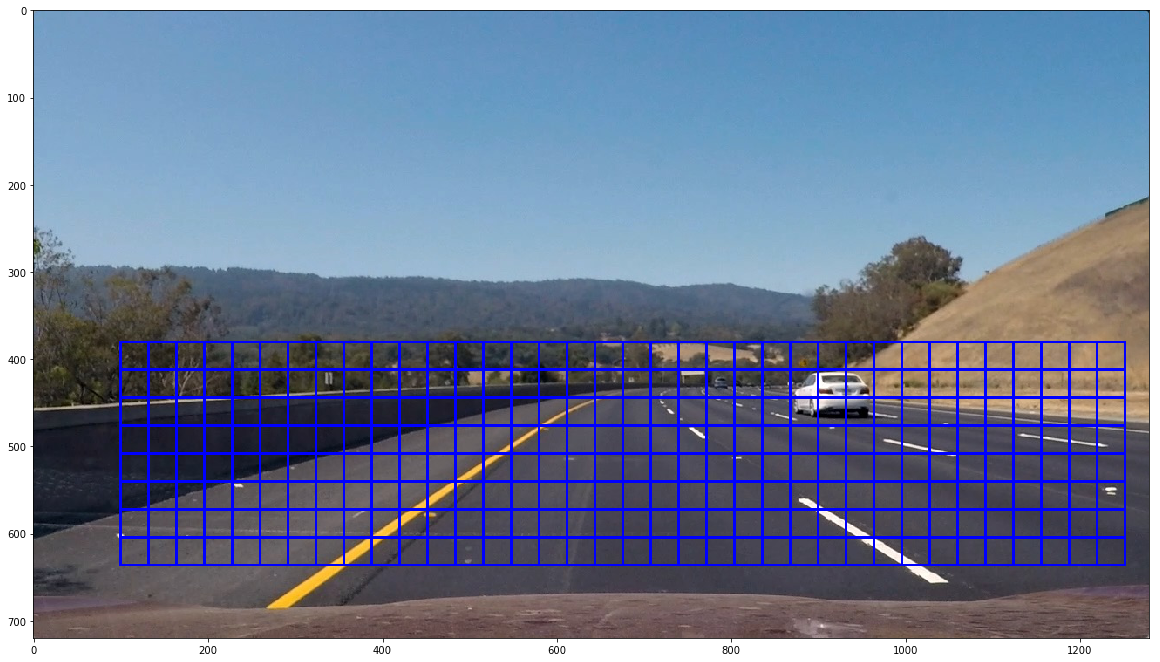

In [10]:
def show_window(image):
    print(xy_windows)
#     for index in range(len(xy_windows)):
#         windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window=xy_windows[index], xy_overlap=xy_overlap)
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window=xy_windows, xy_overlap=xy_overlap)
    icopy = np.copy(image)
    for bbox in windows:
        result = cv2.rectangle(icopy, bbox[0], bbox[1], (0,0,255), 2)
    return result
show_windows = show_window(test_image)
plt.figure(figsize=(20,16))
plt.imshow(show_windows)

1 frame cost 19.704849


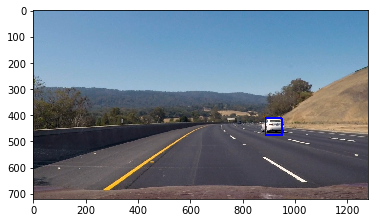

In [11]:
start = time.time()
test_result = pipeline_to_window(test_image, hog_channel=hog_channel,xy_windows=xy_windows,xy_overlap=xy_overlap)
end = time.time()
print("1 frame cost {:2f}".format(end-start))
plt.imshow(test_result)

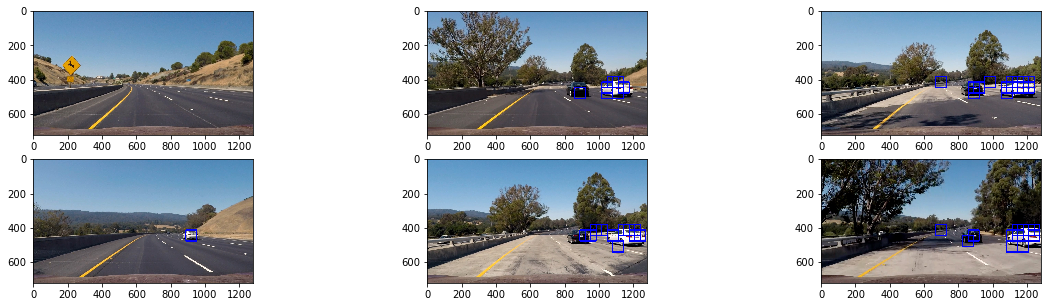

In [12]:
test_image_output = []
for img in test_list:
    test_image_output.append(pipeline_to_window(img, hog_channel=hog_channel,xy_windows=xy_windows,xy_overlap=xy_overlap))
show(test_image_output, 3)

### test images

In [13]:
from scipy.ndimage.measurements import label
def pipeline_hot_map(image, threshold=1,hog_channel=0,xy_overlap=(0.7,0.7),xy_window=(64,64)):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    bbox_list = search_windows(image, windows, clf,X_scaler, color_space=color_space,hist_bins=hist_bins,spatial_size=spatial_size,hog_channel=hog_channel)
    for box in bbox_list:
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    heat[heat <= threshold] = 0
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    result = np.copy(image)
    
    for car_number in range(1, labels[1]+1):
        # print(labels[1], labels[0])
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        result = cv2.rectangle(result, bbox[0], bbox[1], (0,0,255), 6)
    
    return result, heat,labels

time cost: 19.702906


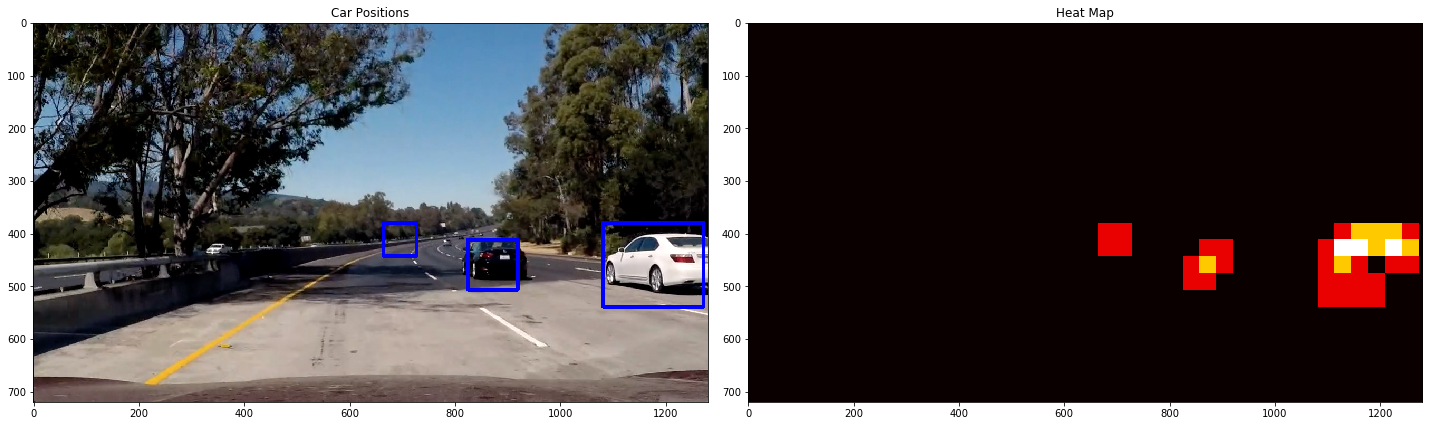

In [14]:
threshold=0
start = time.time()
test_img, test_hot,labels = pipeline_hot_map(test_list[5],threshold=threshold, hog_channel=hog_channel,xy_overlap=xy_overlap,xy_window=xy_windows)
end = time.time()
print("time cost: {:2f}".format(end-start))
fig = plt.figure(figsize=(20,16))
plt.subplot(121)
plt.imshow(test_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(test_hot, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
# plt.imshow(labels[0], cmap='gray')

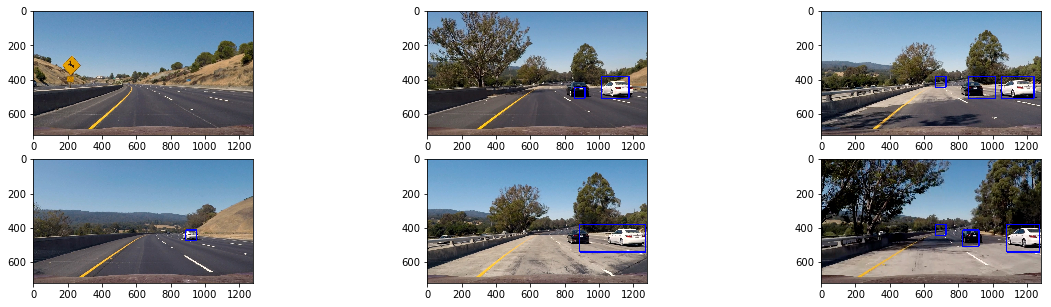

In [15]:
test_heatmap_output = []
for img in test_list:
#     test_heatmap_output.append(pipeline_hot_map(img, hog_channel=hog_channel,xy_overlap=xy_overlap)[0])
    test_heatmap_output.append(pipeline_hot_map(img,threshold=threshold, hog_channel=hog_channel,xy_overlap=xy_overlap,xy_window=xy_windows)[0])
show(test_heatmap_output, 3)

In [19]:
def pipeline_hot_map(image, threshold=1,hog_channel='ALL',xy_overlap=(0.5,0.5),xy_window=(64,64)):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    bbox_list = search_windows(image, windows, clf,X_scaler, color_space=color_space,hist_bins=hist_bins,spatial_size=spatial_size,hog_channel=hog_channel)
    for box in bbox_list:
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    heat[heat <= threshold] = 0
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    result = np.copy(image)
    
    for car_number in range(1, labels[1]+1):
        # print(labels[1], labels[0])
        # Find pixels with each car_number label value
#         print(labels[0])
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        result = cv2.rectangle(result, bbox[0], bbox[1], (0,0,255), 2)
    
    return result

In [ ]:
project_video = "./project_video.mp4"
project_video_output = "./project_video_output2.mp4"
# clip = VideoFileClip(project_video)
# write_clip = clip.fl_image(pipeline_hot_map)
# write_clip.write_videofile(project_video_output)

[MoviePy] >>>> Building video ./project_video_output2.mp4
[MoviePy] Writing audio in project_video_output2TEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:00<00:00, 3381.89it/s]

[MoviePy] Done.
[MoviePy] Writing video ./project_video_output2.mp4



  4%|▍         | 52/1261 [17:22<6:37:26, 19.72s/it]

In [18]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(project_video_output))